### LSTM

```python 
np.random.seed(0)
pd.set_option('display.precision', 2)  
pd.set_option('display.float_format', '{:.2f}'.format) -
```

```python
series_has_nan = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
train_ids = series_has_nan[~series_has_nan].index.tolist()
```

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from itertools import groupby
import gc

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

np.random.seed(0)
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", "{:.2f}".format)

In [5]:
current_directory = os.getcwd()

csv_file_path = os.path.join(current_directory, "input", "data", "train_events.csv")

train_events = pd.read_csv(csv_file_path)

series_has_nan = train_events.groupby("series_id")["step"].apply(
    lambda x: x.isnull().any()
)
train_ids = series_has_nan[~series_has_nan].index.tolist()

train_ids

['08db4255286f',
 '0a96f4993bd7',
 '0cfc06c129cc',
 '1087d7b0ff2e',
 '10f8bc1f7b07',
 '18b61dd5aae8',
 '29c75c018220',
 '31011ade7c0a',
 '3452b878e596',
 '349c5562ee2c',
 '3664fe9233f9',
 '483d6545417f',
 '55a47ff9dc8a',
 '5acc9d63b5fd',
 '5f94bb3e1bed',
 '655f19eabf1e',
 '67f5fc60e494',
 '72bbd1ac3edf',
 '76237b9406d5',
 '7822ee8fe3ec',
 '89bd631d1769',
 '8e32047cbc1f',
 '939932f1822d',
 '9ee455e4770d',
 'a596ad0b82aa',
 'a9a2f7fac455',
 'a9e5f5314bcb',
 'af91d9a50547',
 'b364205aba43',
 'c535634d7dcd',
 'c6788e579967',
 'c68260cc9e8f',
 'ca730dbf521d',
 'd150801f3145',
 'd25e479ecbb7',
 'd515236bdeec',
 'd5e47b94477e']

In [11]:
current_directory = os.getcwd()

parquet_file_path = os.path.join(
    current_directory, "input", "light_weight_data", "Zzzs_train_multi.parquet"
)


def get_multi_light_series(series_ids):
    print(f"fetch {series_ids} \n")
    multi_series = pd.read_parquet(
        parquet_file_path, filters=[("series_id", "in", series_ids)]
    )
    multi_series = multi_series.astype(
        {"series_id": "category", "step": "int16", "awake": "int16"}
    )
    multi_series = add_features(multi_series)
    return multi_series

In [12]:
def add_features(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek

    df["anglez_times_enmo"] = abs(df["anglez"]) * df["enmo"]

    periods = 6  # 1/2 minute
    df["anglez_diff"] = (
        df.groupby("series_id")["anglez"].diff(periods=periods).fillna(method="bfill")
    )
    df["enmo_diff"] = (
        df.groupby("series_id")["enmo"].diff(periods=periods).fillna(method="bfill")
    )

    df["anglez_mean"] = (
        df["anglez"]
        .rolling(periods, center=True)
        .mean()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_mean"] = (
        df["enmo"]
        .rolling(periods, center=True)
        .mean()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )

    df["anglez_min"] = (
        df["anglez"]
        .rolling(periods, center=True)
        .min()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_min"] = (
        df["enmo"]
        .rolling(periods, center=True)
        .min()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )

    df["anglez_max"] = (
        df["anglez"]
        .rolling(periods, center=True)
        .max()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_max"] = (
        df["enmo"]
        .rolling(periods, center=True)
        .max()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )

    df["anglez_std"] = (
        df["anglez"]
        .rolling(periods, center=True)
        .std()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_std"] = (
        df["enmo"]
        .rolling(periods, center=True)
        .std()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )

    df["anglez_diff_rolling"] = (
        df["anglez_diff"]
        .rolling(periods, center=True)
        .mean()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_diff_rolling"] = (
        df["enmo_diff"]
        .rolling(periods, center=True)
        .mean()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    return df

In [13]:
train_all = get_multi_light_series(train_ids[:8])
print(f"memory usage: {train_all.memory_usage().sum() / 1024**2: .2f} MB")

fetch ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 



/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

memory usage:  219.76 MB


/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float32')
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["enmo_std"]   = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float32')
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff_rolling"] = df["anglez_diff"].rolling(periods,center=True).mean().fill

In [14]:
train_all.head()

,series_id,step,timestamp,anglez,enmo,awake,hour,dayofweek,anglez_times_enmo,anglez_diff,...,anglez_mean,enmo_mean,anglez_min,enmo_min,anglez_max,enmo_max,anglez_std,enmo_std,anglez_diff_rolling,enmo_diff_rolling
0,08db4255286f,0,2018-11-05 14:00:00+00:00,-30.85,0.04,1,14,0,1.38,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
1,08db4255286f,1,2018-11-05 14:00:05+00:00,-34.18,0.04,1,14,0,1.51,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
2,08db4255286f,2,2018-11-05 14:00:10+00:00,-33.88,0.05,1,14,0,1.64,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
3,08db4255286f,3,2018-11-05 14:00:15+00:00,-34.28,0.07,1,14,0,2.33,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
4,08db4255286f,4,2018-11-05 14:00:20+00:00,-34.39,0.08,1,14,0,2.64,0.33,...,-33.69,0.07,-34.93,0.04,-30.51,0.11,1.60,0.02,0.33,0.06


Prepare Data

In [15]:
features = [
    "step",
    "hour",
    "dayofweek",
    "anglez_times_enmo",
    "anglez",
    "anglez_diff",
    "anglez_mean",
    "anglez_min",
    "anglez_max",
    "anglez_std",
    "anglez_diff_rolling",
    "enmo",
    "enmo_diff",
    "enmo_mean",
    "enmo_min",
    "enmo_max",
    "enmo_std",
    "enmo_diff_rolling",
]
target = "awake"

scaler = StandardScaler()

df_train_X_scaled = scaler.fit_transform(train_all[features])
df_train_y = train_all[target].values

Split Data

In [16]:
from torch import tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

def_device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
def_device

'mps'

In [17]:
X = tensor(df_train_X_scaled, dtype=torch.float32)
y = tensor(df_train_y, dtype=torch.long)

X.shape, y.shape

(torch.Size([2844900, 18]), torch.Size([2844900]))

In [18]:
split_index = int(len(X) * 0.8)

X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([2275920, 18]),
 torch.Size([2275920]),
 torch.Size([568980, 18]),
 torch.Size([568980]))

In [19]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_ds, val_ds = TimeSeriesDataset(X_train, y_train), TimeSeriesDataset(X_val, y_val)
batch_size = 12 * 60  # 1 hour

train_dl, val_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=False
), DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(def_device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(def_device)
        x = x[:, None, :]  # to 3D dimension
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1, :]))
        return out

In [21]:
from tqdm import tqdm


def accuracy(out, yb):
    return (
        (out.argmax(axis=1) == yb).float().mean()
    )  # Evaluate the accuracy of the model.


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1} train")
        progress_bar = tqdm(train_dl)
        model.train(True)
        for xb, yb in progress_bar:
            xb, yb = xb.to(def_device), yb.to(def_device)
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            progress_bar.set_description(f"Loss: {loss.item():.3f}")
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0.0, 0.0, 0
            print(f"Starting epoch {epoch+1} eval")
            progress_bar = tqdm(valid_dl)
            for xb, yb in progress_bar:
                xb, yb = xb.to(def_device), yb.to(def_device)
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n
        print(
            f"epoch:{epoch}, loss: {tot_loss/count:.2f}, accuracy: {tot_acc/count:.2f}"
        )
    return tot_loss / count, tot_acc / count


def predict(x):
    with torch.no_grad():
        predicted = model(x.to(def_device)).to("cpu")
    score = F.log_softmax(predicted, -1).exp()
    value = score.argmax(axis=1)
    return score, value

In [22]:
input_size = len(features)
hidden_size = 32  # like 1 2 4 32 64
num_layers = 2
output_size = 2

model = LSTM(input_size, hidden_size, num_layers, output_size)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = F.cross_entropy

model.to(def_device)
model

LSTM(
  (lstm): LSTM(18, 32, num_layers=2, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [23]:
%time loss,acc = fit(4, model, loss_func, opt, train_dl, val_dl)

Starting epoch 1 train


  0%|          | 0/3161 [00:00<?, ?it/s]

Loss: 0.239: 100%|██████████| 3161/3161 [00:35<00:00, 89.98it/s] 


Starting epoch 1 eval


100%|██████████| 791/791 [00:04<00:00, 171.64it/s]


epoch:0, loss: 0.18, accuracy: 0.93
Starting epoch 2 train


Loss: 0.137: 100%|██████████| 3161/3161 [00:33<00:00, 93.60it/s] 


Starting epoch 2 eval


100%|██████████| 791/791 [00:04<00:00, 184.99it/s]


epoch:1, loss: 0.17, accuracy: 0.93
Starting epoch 3 train


Loss: 0.135: 100%|██████████| 3161/3161 [00:33<00:00, 94.49it/s] 


Starting epoch 3 eval


100%|██████████| 791/791 [00:04<00:00, 184.02it/s]


epoch:2, loss: 0.16, accuracy: 0.94
Starting epoch 4 train


Loss: 0.137: 100%|██████████| 3161/3161 [00:32<00:00, 97.78it/s] 


Starting epoch 4 eval


100%|██████████| 791/791 [00:04<00:00, 184.36it/s]

epoch:3, loss: 0.15, accuracy: 0.94
CPU times: user 2min 3s, sys: 20.3 s, total: 2min 24s
Wall time: 2min 32s


In [24]:
xb, yb = next(iter(train_dl))
print(xb.shape, yb.shape)

torch.Size([720, 18]) torch.Size([720])


accuracy: 1.0


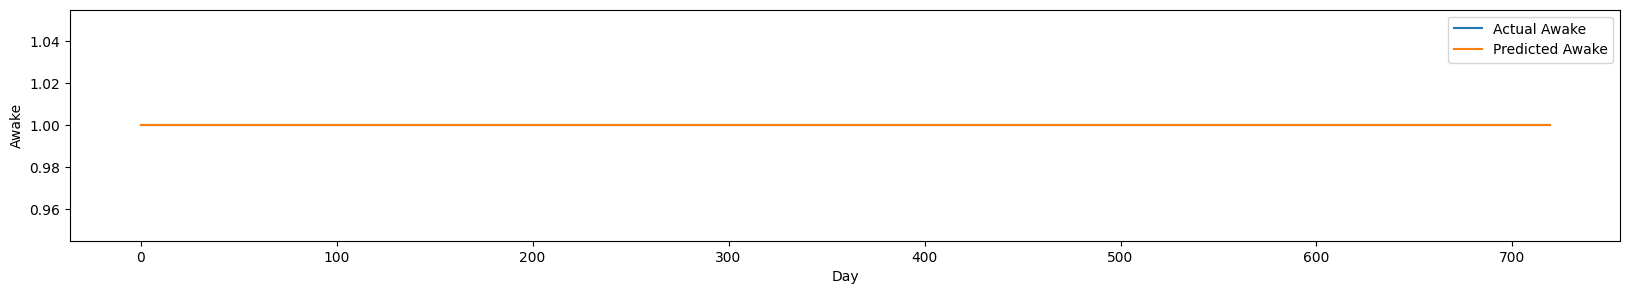

In [25]:
score, pred_value = predict(xb)
print(f"accuracy: {accuracy(score, yb)}")


def plot_predicate(act_value, pred_value):
    plt.figure(figsize=(20, 3))
    plt.plot(act_value, label="Actual Awake")
    plt.plot(pred_value, label="Predicted Awake")
    plt.xlabel("Day")
    plt.ylabel("Awake")
    plt.legend()
    plt.show()


plot_predicate(yb, pred_value)

In [26]:
def data_transform(df):
    if df.empty:
        raise ValueError("The input dataframe is empty.")
    df = add_features(df)
    if not set(features).issubset(df.columns):
        raise ValueError("Some features are not present in the dataframe.")
    df_scaler = scaler.transform(df[features])
    return tensor(df_scaler, dtype=torch.float32)

In [27]:
print(train_ids[30:32])
print(train_all.columns)
print(train_ids)

train_all.loc[train_all["series_id"] == "05e1944c3818"]


train_all

['c6788e579967', 'c68260cc9e8f']
Index(['series_id', 'step', 'timestamp', 'anglez', 'enmo', 'awake', 'hour',
       'dayofweek', 'anglez_times_enmo', 'anglez_diff', 'enmo_diff',
       'anglez_mean', 'enmo_mean', 'anglez_min', 'enmo_min', 'anglez_max',
       'enmo_max', 'anglez_std', 'enmo_std', 'anglez_diff_rolling',
       'enmo_diff_rolling'],
      dtype='object')
['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a', '3452b878e596', '349c5562ee2c', '3664fe9233f9', '483d6545417f', '55a47ff9dc8a', '5acc9d63b5fd', '5f94bb3e1bed', '655f19eabf1e', '67f5fc60e494', '72bbd1ac3edf', '76237b9406d5', '7822ee8fe3ec', '89bd631d1769', '8e32047cbc1f', '939932f1822d', '9ee455e4770d', 'a596ad0b82aa', 'a9a2f7fac455', 'a9e5f5314bcb', 'af91d9a50547', 'b364205aba43', 'c535634d7dcd', 'c6788e579967', 'c68260cc9e8f', 'ca730dbf521d', 'd150801f3145', 'd25e479ecbb7', 'd515236bdeec', 'd5e47b94477e']


,series_id,step,timestamp,anglez,enmo,awake,hour,dayofweek,anglez_times_enmo,anglez_diff,...,anglez_mean,enmo_mean,anglez_min,enmo_min,anglez_max,enmo_max,anglez_std,enmo_std,anglez_diff_rolling,enmo_diff_rolling
0,08db4255286f,0,2018-11-05 14:00:00+00:00,-30.85,0.04,1,14,0,1.38,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
1,08db4255286f,1,2018-11-05 14:00:05+00:00,-34.18,0.04,1,14,0,1.51,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
2,08db4255286f,2,2018-11-05 14:00:10+00:00,-33.88,0.05,1,14,0,1.64,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
3,08db4255286f,3,2018-11-05 14:00:15+00:00,-34.28,0.07,1,14,0,2.33,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
4,08db4255286f,4,2018-11-05 14:00:20+00:00,-34.39,0.08,1,14,0,2.64,0.33,...,-33.69,0.07,-34.93,0.04,-30.51,0.11,1.60,0.02,0.33,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844895,29c75c018220,5463,2018-05-01 13:14:35+00:00,-12.78,0.02,1,13,1,0.23,-2.80,...,-13.84,0.02,-15.10,0.02,-12.78,0.03,0.97,0.00,-1.66,-0.00
2844896,29c75c018220,5464,2018-05-01 13:14:40+00:00,-13.14,0.02,1,13,1,0.27,-3.27,...,-14.28,0.02,-15.69,0.02,-12.78,0.03,1.13,0.00,-2.63,-0.00
2844897,29c75c018220,5465,2018-05-01 13:14:45+00:00,-14.72,0.02,1,13,1,0.36,-4.70,...,-14.34,0.02,-15.69,0.02,-12.78,0.03,1.20,0.00,-2.61,0.00
2844898,29c75c018220,5466,2018-05-01 13:14:50+00:00,-15.69,0.02,1,13,1,0.30,-2.61,...,-14.34,0.02,-15.69,0.02,-12.78,0.03,1.20,0.00,-2.61,0.00


fetch ['c6788e579967'] 



/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

accuracy: 0.95


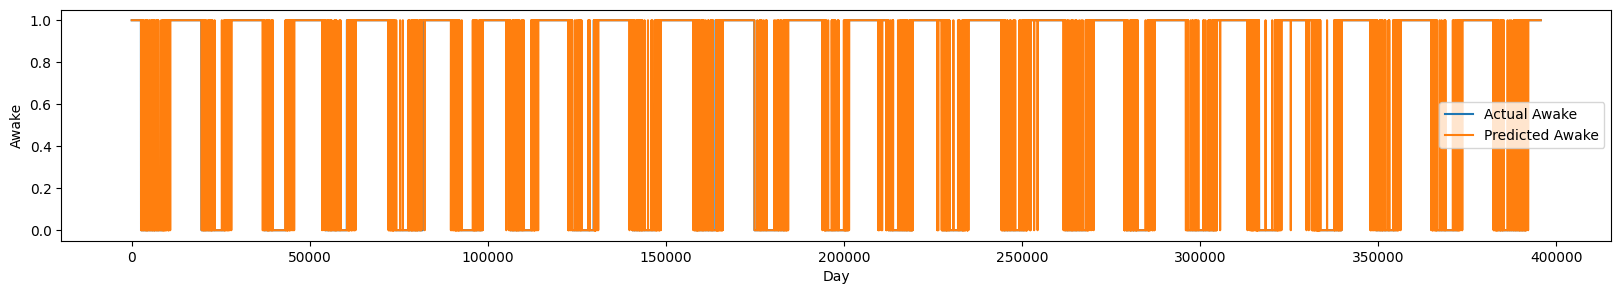

fetch ['c68260cc9e8f'] 



/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

accuracy: 0.93


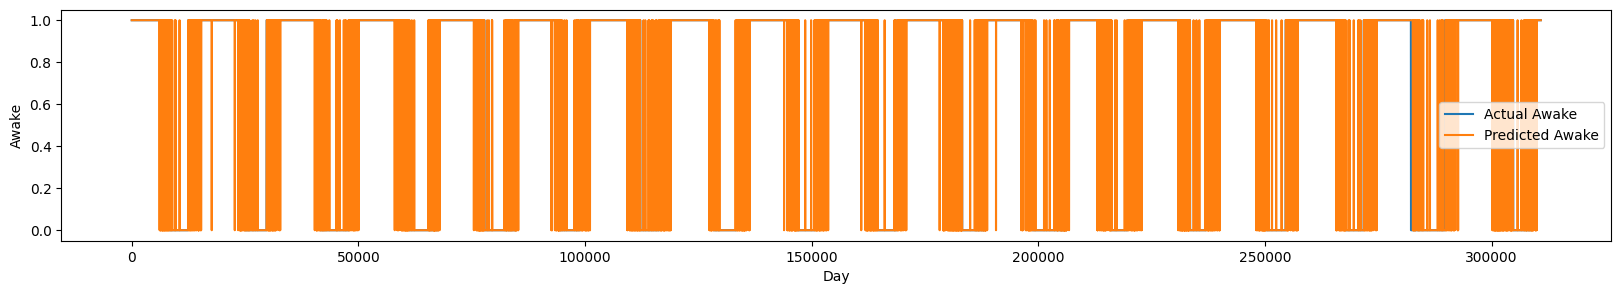

In [28]:
def predict_train_set(predict_series_ids):
    for series_id in predict_series_ids:
        pred_df = get_multi_light_series([series_id])
        pred_data = data_transform(pred_df)
        score, pred_value = predict(pred_data.to(def_device))
        act_y = tensor(pred_df["awake"].to_numpy())
        print(f"accuracy: {accuracy(score, act_y):.2f}")
        plot_predicate(pred_df["awake"], pred_value)


predict_train_set(train_ids[30:32])

In [29]:
del train_all, X_train, y_train
gc.collect()

3383

In [31]:
current_directory = os.getcwd()

parquet_file_path = os.path.join(
    current_directory, "input", "data", "test_series.parquet"
)


def get_test_series_ids():
    return pd.read_parquet(parquet_file_path, columns=["series_id"])[
        "series_id"
    ].unique()


def get_test_series(series_id):
    return pd.read_parquet(
        parquet_file_path,
        columns=["series_id", "timestamp", "anglez", "enmo", "step"],
        filters=[("series_id", "=", series_id)],
    )


def get_event(df):
    lstCV = zip(df.series_id, df.smooth)
    lstPOI = []
    for (c, v), g in groupby(
        lstCV, lambda cv: (cv[0], cv[1] != 0 and not pd.isnull(cv[1]))
    ):
        llg = sum(1 for item in g)
        if v is False:
            lstPOI.extend([0] * llg)
        else:
            lstPOI.extend(["onset"] + (llg - 2) * [0] + ["wakeup"] if llg > 1 else [0])
    return lstPOI

In [32]:
def multi_series_prediction(test_series_ids):
    for series_id in test_series_ids:
        single_series = get_test_series(series_id)
        X_test = data_transform(single_series)
        score, _ = predict(X_test.to(def_device))

        single_series["not_awake"] = score[:, 0]
        single_series["awake"] = score[:, 1]

        smoothing_length = 2 * 230
        single_series["score"] = (
            single_series["awake"]
            .rolling(smoothing_length, center=True)
            .mean()
            .fillna(method="bfill")
            .fillna(method="ffill")
        )
        single_series["smooth"] = (
            single_series["not_awake"]
            .rolling(smoothing_length, center=True)
            .mean()
            .fillna(method="bfill")
            .fillna(method="ffill")
        )
        single_series["smooth"] = single_series["smooth"].round()
        single_series["event"] = get_event(single_series)

        df = (
            single_series.loc[single_series["event"] != 0][
                ["series_id", "step", "event", "score"]
            ]
            .copy()
            .reset_index(drop=True)
        )
        df.to_csv(f"{series_id}.csv", index=False)
        del df, single_series
        gc.collect()
    return


def combine_predictions(test_series):
    sub = pd.read_csv(f"{test_series[0]}.csv")
    for series in test_series[1:]:
        temp = pd.read_csv(f"{series}.csv")
        sub = pd.concat([sub, temp], ignore_index=True)
        del temp
        gc.collect()
    sub = sub.copy().reset_index(drop=True).reset_index(names="row_id")
    sub.to_csv("submission.csv", index=False)
    return sub

In [33]:
test_series_ids = get_test_series_ids()
test_series_ids

array(['038441c925bb', '03d92c9f6f8a', '0402a003dae9'], dtype=object)

In [34]:
multi_series_prediction(test_series_ids)
sub = combine_predictions(test_series_ids)
sub.head()

/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["enmo_diff"]   = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')
/var/folders/hb/_y

,row_id,series_id,step,event,score


LSTM